In [1]:
import  numpy as np
import matplotlib.pyplot as plt

from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [2]:
from qmatches.gates import GZB
from qmatches.ansatz import gzb_ansatz_cell

In [3]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return np.real(ref)

In [4]:
def var_circ_qiskit(nr_o,nr_e,params):
    
    circ = QuantumCircuit(nr_o)
    for i in range(nr_e):
        circ.x(i)
    circ=gzb_ansatz_cell(circ,nr_o, nr_e,thetas=params,hidden=False)
    return circ

In [5]:
# Hidrogen (H_2)

basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'H .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())
    
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)

HF energy: -1.3194643767935124
# nr. of electrons: 2
# nr. of spin orbitals: 4


/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/chemistry/fermionic_operator.py:394: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  task_args=(threshold,), num_processes=aqua_globals.num_processes)


Representation: paulis, qubits: 4, size: 15
IIII	(-0.8517840380466506+0j)
IIIZ	(0.10053557435398455+0j)
IIZI	(-0.049032364414860446+0j)
IZII	(0.10053557435398452+0j)
ZIII	(-0.04903236441486046+0j)
IIZZ	(0.08678749878785741+0j)
IZIZ	(0.14120468151365045+0j)
XXYY	(0.05575552226867875+0j)
YYYY	(0.05575552226867875+0j)
XXXX	(0.05575552226867875+0j)
YYXX	(0.05575552226867875+0j)
ZIIZ	(0.14254302105653616+0j)
IZZI	(0.14254302105653616+0j)
ZIZI	(0.14891189696596438+0j)
ZZII	(0.08678749878785741+0j)

[0. 0. 0. 0.]


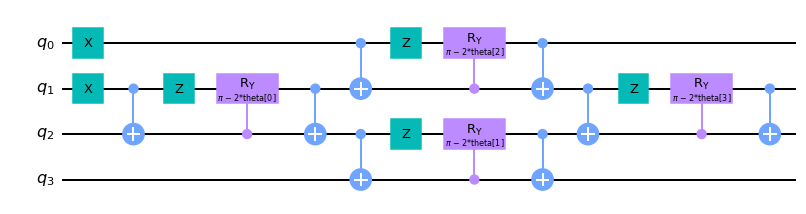

In [6]:
circ=var_circ_qiskit(nr_o,nr_e,params = ParameterVector('theta',length=nr_par))                  
circ.draw('mpl')

In [7]:
backend = BasicAer.get_backend('qasm_simulator')

In [8]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

In [9]:
seed= 1257
shots=1000
optim = COBYLA(maxiter=1000)

/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [10]:
vqe= VQE(operator=qubitOp, var_form=circ, optimizer=optim,callback=store_intermediate_result)

/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:72: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


In [11]:
# run quantum algorithm with shots
counts=[]
values=[]
params=[]
deviation=[]


quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result_shots = vqe.run(quantum_instance)

/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


VQE result: -1.346346575021432
Exact solver: -1.3934519713739584


/Users/voicutu/opt/anaconda3/envs/QMatches/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


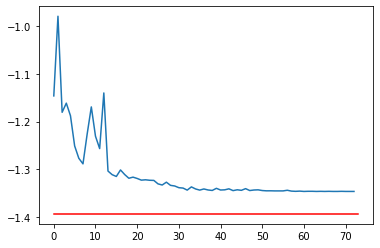

In [12]:
exact=Exact_solver(qubitOp)
print("VQE result:",values[-1])
print("Exact solver:",exact[0])

plt.plot(values)

x=np.linspace(0,len(values))
y=[exact for i in range(len(x))]
plt.plot(x, y, '-r', label='Ideal_value')

plt.show()